## Hidden Markov Models

### References
* https://zombieprocess.wordpress.com/2014/03/21/hidden-markov-models-in-python/
* https://inst.eecs.berkeley.edu/~cs188/sp08/projects/hmm/project_hmm.html
* https://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf

In [1]:
%run "../common.ipynb"

In [213]:
hmm = HMM()
hmm.pi = np.array([0.5, 0.5])
hmm.A = np.array([[0.6, 0.4],
                  [0.12, 0.88]])
hmm.B = np.array([[0.8, 0.1, 0.1],                          
                  [0.0, 0.0, 1.0]])

o,s = hmm.simulate(50)

print (o,'\n',s)

[ 0.  2.  2.  2.  2.  0.  2.  2.  2.  2.  0.  1.  0.  0.  1.  2.  0.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  0.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.] 
 [ 0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


Actual probabilities
 [ 0.5  0.5]
Estimated initial probabilities
 [ 1.  0.]
Actual state transition probabililities
 [[ 0.85  0.15]
 [ 0.12  0.88]]
Estimated state transition probabililities
 [[ 0.865  0.135]
 [ 0.134  0.866]]
Actual observation probabililities
 [[ 0.8  0.1  0.1]
 [ 0.   0.   1. ]]
Estimated observation probabililities
 [[ 0.793  0.106  0.101]
 [ 0.001  0.     0.999]]


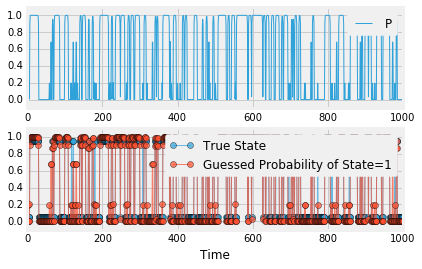

In [225]:
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

class HMM:
    def __init__(self):
        pass

    def simulate(self,nSteps):

        def drawFrom(probs):
            return np.where(np.random.multinomial(1,probs) == 1)[0][0]

        observations = np.zeros(nSteps)
        states = np.zeros(nSteps)
        states[0] = drawFrom(self.pi)
        observations[0] = drawFrom(self.B[states[0],:])
        for t in range(1,nSteps):
            states[t] = drawFrom(self.A[states[t-1],:])
            observations[t] = drawFrom(self.B[states[t],:])
        return observations,states


    def train(self,observations,criterion,graphics=False):
        if graphics:
            plt.ion()

        nStates = self.A.shape[0]
        nSamples = len(observations)

        A = self.A
        B = self.B
        pi = copy(self.pi)
        
        done = False
        while not done:

            # alpha_t(i) = P(O_1 O_2 ... O_t, q_t = S_i | hmm)
            # Initialize alpha
            alpha = np.zeros((nStates,nSamples))
            c = np.zeros(nSamples) #scale factors
            alpha[:,0] = pi.T * self.B[:,observations[0]]
            c[0] = 1.0/np.sum(alpha[:,0])
            alpha[:,0] = c[0] * alpha[:,0]
            # Update alpha for each observation step
            for t in range(1,nSamples):
                alpha[:,t] = np.dot(alpha[:,t-1].T, self.A).T * self.B[:,observations[t]]
                c[t] = 1.0/np.sum(alpha[:,t])
                alpha[:,t] = c[t] * alpha[:,t]

            # beta_t(i) = P(O_t+1 O_t+2 ... O_T | q_t = S_i , hmm)
            # Initialize beta
            beta = np.zeros((nStates,nSamples))
            beta[:,nSamples-1] = 1
            beta[:,nSamples-1] = c[nSamples-1] * beta[:,nSamples-1]
            # Update beta backwards from end of sequence
            for t in range(len(observations)-1,0,-1):
                beta[:,t-1] = np.dot(self.A, (self.B[:,observations[t]] * beta[:,t]))
                beta[:,t-1] = c[t-1] * beta[:,t-1]

            xi = np.zeros((nStates,nStates,nSamples-1));
            for t in range(nSamples-1):
                denom = np.dot(np.dot(alpha[:,t].T, self.A) * self.B[:,observations[t+1]].T,
                               beta[:,t+1])
                for i in range(nStates):
                    numer = alpha[i,t] * self.A[i,:] * self.B[:,observations[t+1]].T * \
                            beta[:,t+1].T
                    xi[i,:,t] = numer / denom
  
            # gamma_t(i) = P(q_t = S_i | O, hmm)
            gamma = np.squeeze(np.sum(xi,axis=1))
            # Need final gamma element for new B
            prod =  (alpha[:,nSamples-1] * beta[:,nSamples-1]).reshape((-1,1))
            gamma = np.hstack((gamma,  prod / np.sum(prod))) #append one more to gamma!!!

            newpi = gamma[:,0]
            newA = np.sum(xi,2) / np.sum(gamma[:,:-1],axis=1).reshape((-1,1))
            newB = copy(B)

            if graphics:
                plt.subplot(2,1,1)
                plt.cla()
                #plt.plot(gamma.T)
                plt.plot(gamma[1])
                plt.ylim(-0.1,1.1)
                plt.legend(('Probability State=1'))
                plt.xlabel('Time')
                plt.draw()
            
            numLevels = self.B.shape[1]
            sumgamma = np.sum(gamma,axis=1)
            for lev in range(numLevels):
                mask = observations == lev
                newB[:,lev] = np.sum(gamma[:,mask],axis=1) / sumgamma

            if np.max(abs(pi - newpi)) < criterion and \
                   np.max(abs(A - newA)) < criterion and \
                   np.max(abs(B - newB)) < criterion:
                done = 1;
  
            A[:],B[:],pi[:] = newA,newB,newpi

        self.A[:] = newA
        self.B[:] = newB
        self.pi[:] = newpi
        self.gamma = gamma


#if __name__ == '__main__':
def main():
    np.set_printoptions(precision=3,suppress=True)
    if True:
        #'Two states, three possible observations in a state'

        hmm = HMM()
        hmm.pi = np.array([0.5, 0.5])
        hmm.A = np.array([[0.85, 0.15],
                          [0.12, 0.88]])
        hmm.B = np.array([[0.8, 0.1, 0.1],                          
                          [0.0, 0.0, 1.0]])
        
        
        hmmguess = HMM()
        hmmguess.pi = np.array([0.5, 0.5])
        hmmguess.A = np.array([[0.5, 0.5],
                               [0.5, 0.5]])
        hmmguess.B = np.array([[0.3, 0.3, 0.4],
                               [0.2, 0.5, 0.3]])
    else:
        #three states
        print ("Error....this example with three states is not working correctly.")
        hmm = HMM()
        hmm.pi = np.array([0.1, 0.4, 0.5])
        hmm.A = np.array([[0.7, 0.2, 0.1],
                          [0.1, 0.6, 0.3],
                          [0.4, 0.2, 0.4]])
        hmm.B = np.array([[0.5, 0.3, 0.2],
                          [0.1, 0.6, 0.3],
                          [0.0, 0.3, 0.7]])
        hmmguess = HMM()
        hmmguess.pi = np.array([0.333, 0.333, 0.333])
        hmmguess.A = np.array([[0.3333, 0.3333, 0.3333],
                               [0.3333, 0.3333, 0.3333],
                               [0.3333, 0.3333, 0.3333]])
        hmmguess.B = np.array([[0.3, 0.3, 0.4],
                               [0.2, 0.5, 0.3],
                               [0.3, 0.3, 0.4]])

    o,s = hmm.simulate(1000)
    hmmguess.train(o,0.0001,graphics=True)

    print ('Actual probabilities\n',hmm.pi)
    print ('Estimated initial probabilities\n',hmmguess.pi)
    
    print ('Actual state transition probabililities\n',hmm.A)
    print ('Estimated state transition probabililities\n',hmmguess.A)

    print ('Actual observation probabililities\n',hmm.B)
    print ('Estimated observation probabililities\n',hmmguess.B)

    plt.subplot(2,1,2)
    plt.cla()
    plt.plot(np.vstack((s*0.9+0.05,hmmguess.gamma[1,:])).T,'-o',alpha=0.7)
    plt.legend(('True State','Guessed Probability of State=1'))
    plt.ylim(-0.1,1.1)
    plt.xlabel('Time')
    plt.draw()

main()

PI: [ 0.5  0.5]
A:
[[ 0.85  0.15]
 [ 0.12  0.88]]
B:
[[ 0.8  0.1  0.1]
 [ 0.   0.   1. ]]
O:
[ 0.  1.  1.  0.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  0.  1.  2.  0.  2.  0.  2.  0.  0.  0.  0.  2.  0.  2.  2.  2.  0.  0.  2.  2.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  2.  2.  2.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  2.  2.  0.  0.  2.]
T:
[ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.]


In [232]:
np.zeros((2,2,10))

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])